# CIFAR - a sister dataset of Fashion MNIST

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

#### Some utils for evaluating the model

In [ ]:
import sys, os
sys.path.append(os.path.abspath("../utils/confusion_matrix_plot.py"))

from confusion_matrix_plot import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [29]:
# Augment the data
transform_train = transforms.Compose([
    # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomAffine(0, (0.1, 0.1)),
    # transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomInvert(),
    transforms.ToTensor()
])

### Load in the dataset

In [30]:
# Train dataset
train_dataset = CIFAR10(
    root=".",
    train=True,
    transform=transform_train,
    download=False
)

In [31]:
# Test dataset
test_dataset = CIFAR10(
    root=".",
    train=False,
    transform=transforms.ToTensor(),
    download=False
)

#### Examine the data

In [32]:
len(train_dataset.data), len(train_dataset.targets), len(test_dataset.data), len(test_dataset.targets)
X_train = torch.tensor(train_dataset.data)
y_train = torch.tensor(train_dataset.targets)
X_test = torch.tensor(test_dataset.data)
y_test = torch.tensor(test_dataset.targets)
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [33]:
torch.max(y_train), torch.min(y_train)

(tensor(9), tensor(0))

In [34]:
# Real labels
classes = train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

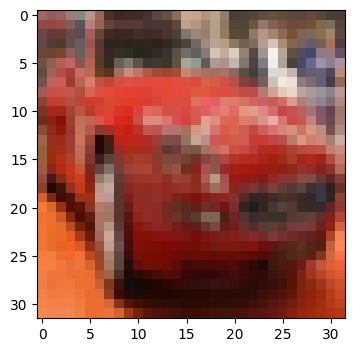

In [35]:
# Sample data
fig = plt.figure(figsize=(4, 4))
plt.imshow(X_train[5])
plt.show()

# Build the model

In [47]:
class CNN(nn.Module):
    def __init__(self, num_outs: int, num_hiddens: int, drop_out_p: float):
        super(CNN, self).__init__()
        assert 0 <= drop_out_p <= 1
        # Convolution layer
        # Pad = 1 => output same size after conv
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2)
        )

        # Size: 32 -> 16 -> 8 -> 4

        self.flatten_size = 4 * 4 * 128

        # ANN
        self.dense_layer = nn.Sequential(
            nn.Dropout(drop_out_p),
            nn.Linear(self.flatten_size, num_hiddens),
            nn.ReLU(),
            nn.Dropout(drop_out_p),
            nn.Linear(num_hiddens, num_outs),
        )

    def forward(self, X):
        out = self.conv_layer_1(X)
        out = self.conv_layer_2(out)
        out = self.conv_layer_3(out)
        out = out.view(out.size(0), -1)
        out = self.dense_layer(out)
        return out

In [37]:
def configure(model: nn.Module, device: torch.device, lr: float, optim_method):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    if optim_method == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)
    return criterion, optimizer

In [38]:
def batch_gd(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, device: torch.device,
                train_loader: DataLoader, test_loader: DataLoader, num_epochs: int, record=False):
    assert 0 <= num_epochs

    # Record the loss over time
    loss_history = np.zeros(num_epochs)
    test_history = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        # Train mode
        model.train()

        # Loss over the same epoch
        loss_epoch = []
        for inputs, targets in train_loader:
            # Zero the gradient
            optimizer.zero_grad()

            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outs = model(inputs)
            loss = criterion(outs, targets)

            # Record the train loss
            loss_epoch.append(loss.item())

            # Backward pass
            loss.backward()
            optimizer.step()

        # Average loss after 1 epoch
        loss_history[epoch] = np.mean(loss_epoch)

        # Eval mode
        model.eval()
        test_epoch = []
        for inputs, targets in test_loader:
            # Zero the gradient
            optimizer.zero_grad()

            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outs = model(inputs)
            test_loss = criterion(outs, targets)

            # Record test loss
            test_epoch.append(test_loss.item())

        # Average loss
        test_history[epoch] = np.mean(test_epoch)

    if record:
        print(f"Epoch {epoch}/{num_epochs}: Train loss={loss_history[epoch]}; Test loss={test_history[epoch]}")

    return loss_history, test_history

### Train the model

In [39]:
# Number of outputs
num_outs = 10

# The device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
num_epochs = 80
lr = 0.001
num_hiddens = 1024
drop_out = 0.2
optim_method = "Adam"

In [40]:
device

device(type='cuda', index=0)

In [49]:
# Instantiate the model, loss func, and optimizer
model = CNN(num_outs, num_hiddens, drop_out)
criterion, optimizer = configure(model, device, lr, optim_method)

In [42]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [43]:
from time import perf_counter

In [50]:
# Train the model
start = perf_counter()
loss_history, test_history = batch_gd(model, criterion, optimizer, device, train_loader, test_loader, num_epochs)
end =  perf_counter()
f"{end-start:.4f}s needed!"

'1502.9215s needed!'

### Evaluate the model

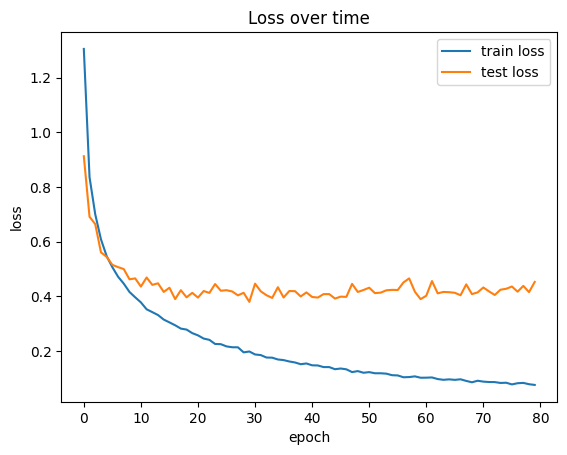

In [51]:
# Plot the loss over time
plt.title("Loss over time")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_history, label="train loss")
plt.plot(test_history, label="test loss")
plt.legend()
plt.show()

#### Model accuracy

In [52]:
def compute_accuracy(model: nn.Module, device, data_loader: DataLoader):
    model.eval()
    n_correct, n_total = 0, 0
    for inputs, targets in data_loader:
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)

        outs = model(inputs)
        _, preds = torch.max(outs, 1)

        # compute the accuracy
        n_total += targets.shape[0]
        n_correct += torch.sum((preds == targets)).item()

    return n_correct / n_total

In [53]:
# Compute the accuracies
train_acc = compute_accuracy(model, device, train_loader)
test_acc = compute_accuracy(model, device, test_loader)
f"Train accuracy: {train_acc}; Test accuracy: {test_acc}."

'Train accuracy: 0.98528; Test accuracy: 0.8899.'

### Confuion matrix

Confusion matrix with no normalization
[[904   6  17   6   5   1   2   2  44  13]
 [  6 958   0   0   2   0   1   1   7  25]
 [ 34   2 859  31  36   8  16   6   4   4]
 [ 17   3  32 813  19  58  24  10  11  13]
 [  3   0  26  31 891  17  14  16   1   1]
 [  7   1  25 132  23 783   9  15   3   2]
 [ 10   4  16  29  11   5 918   3   2   2]
 [ 10   0  17  25  27  19   3 894   3   2]
 [ 18   9   2   3   2   1   0   0 956   9]
 [ 10  45   2   1   1   1   2   1  14 923]]


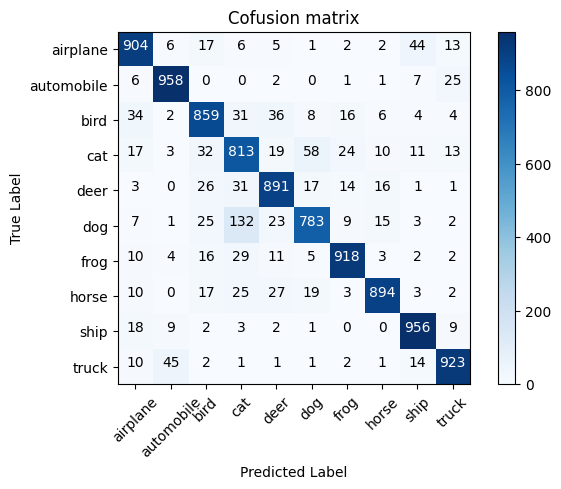

In [54]:
y_test = test_dataset.targets
p_test = np.array([])

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    outs = model(inputs)
    _, preds = torch.max(outs, 1)

    p_test = np.concatenate((p_test, preds.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, classes)

### Some misidentified data

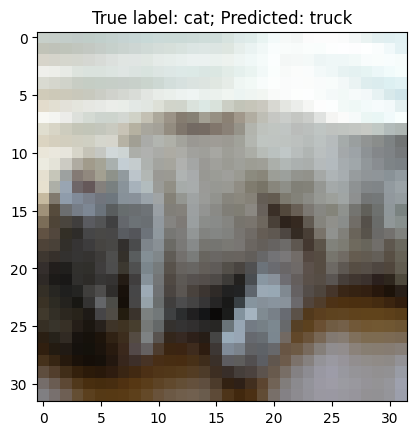

In [58]:
X_test = test_dataset.data
y_test = np.array(y_test).astype(np.int8)
p_test = p_test.astype(np.int8)
misidentified = np.where(p_test != y_test)[0]
sample_idx = np.random.choice(misidentified)
plt.title(f"True label: {classes[y_test[sample_idx]]}; Predicted: {classes[p_test[sample_idx]]}")
plt.imshow(X_test[sample_idx])
plt.show()